In [1]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import time 
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 
from sklearn.model_selection import TimeSeriesSplit
from scipy.sparse import csr_matrix
%matplotlib inline

C:\Users\Yuga\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [2]:
sales = pd.read_csv('../data/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('../data/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('../data/sell_prices.csv')
prices.name = 'prices'

In [3]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

## Reduce memory

In [5]:
#credit to @MichaelMayer on https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if col == 'date':
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            else:
                df[col] = df[col].astype('category')
                
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


calendar = reduce_mem_usage(calendar)
sales = reduce_mem_usage(sales)
prices = reduce_mem_usage(prices)

Mem. usage decreased to  0.13 Mb (40.4% reduction)
Mem. usage decreased to 97.11 Mb (78.6% reduction)
Mem. usage decreased to 45.76 Mb (78.1% reduction)


## Melting Data

In [6]:
#meltin data to merge sales of item on every day
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sale').dropna()
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
df = pd.merge(df, calendar, on='d', how='left')
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [8]:
#add price of item on each week
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [10]:
df.to_pickle('data_for_eda.pkl')

## Feature Engineering

In [11]:
#store column of id and store_id for submission later on, cuz df will be changed
d_id = dict(zip(df.id.cat.codes, df.id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))

In [12]:
#encoding on categorical data (which have been converted to a 'category' dtype in reduce_mem()), 
#so we can use DataFrame.cat.codes to transform them, otherwise we have to use LabelEncoder or OneHostEncoder
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
#         df[cols[i]] = df[cols[i]].cat.codes.astype("int16")
#         df[cols[i]] -= df[cols[i]].min()
        

df.drop('date',axis=1,inplace=True)

In [13]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN


In [14]:
#add lags(shift) to generate training data
for lag in [1,7,14,28,56]:
    df['sale_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sale'].transform(lambda x: x.shift(lag)).astype(np.float16)

In [17]:
# generating rolling mean of sales in different windwos size [7,30,60,120, 180] ([week, month, 2month, quater, half year])
for size in [7,30,60,120, 180]:
    df['rolling_sale_mean_'+str(size)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sale'].transform(lambda x: x.rolling(window=size).mean()).astype(np.float16)

In [20]:
#generating trend of sale, further-> price
df['daily_avg_sale'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sale'].transform('mean').astype(np.float16)
df['avg_sale'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sale'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sale'] - df['avg_sale']).astype(np.float16)
df.drop(['daily_avg_sale','avg_sale'],axis=1,inplace=True)

In [21]:
df = df[df['d']>=56]
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58357860 entries, 1676950 to 60034809
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int16  
 1   item_id                int16  
 2   dept_id                int8   
 3   cat_id                 int8   
 4   store_id               int8   
 5   state_id               int8   
 6   d                      int16  
 7   sale                   int16  
 8   wm_yr_wk               int16  
 9   weekday                int8   
 10  wday                   int8   
 11  month                  int8   
 12  year                   int16  
 13  event_name_1           int8   
 14  event_type_1           int8   
 15  event_name_2           int8   
 16  event_type_2           int8   
 17  snap_CA                int8   
 18  snap_TX                int8   
 19  snap_WI                int8   
 20  sell_price             float16
 21  sale_lag_1             float16
 22  sale_lag_7

In [22]:
df.to_pickle('data.pkl')
del df
gc.collect();

## Modeling

In [6]:
data = pd.read_pickle('data.pkl')

In [7]:
eda_data = pd.read_pickle('data_for_eda.pkl')

In [8]:
d_id = dict(zip(df.id.cat.codes, df.id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))

In [9]:
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sale']] #1914 - 1942 -> ground-truth
test = data[data['d']>=1942][['id','d','sale']] #1942 - 1969 -> to predict
eval_preds = test['sale']
valid_preds = valid['sale']

In [10]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sale',axis=1), df[df['d']<1914]['sale']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sale',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sale']
    X_test = df[df['d']>=1942].drop('sale',axis=1)
    
    #Train and validate
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('Predicting sales for Store: {}'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.01677	training's l2: 1.03382	valid_1's rmse: 0.852899	valid_1's l2: 0.727437
[40]	training's rmse: 0.967251	training's l2: 0.935574	valid_1's rmse: 0.817779	valid_1's l2: 0.668762
[60]	training's rmse: 0.943312	training's l2: 0.889837	valid_1's rmse: 0.804914	valid_1's l2: 0.647887
[80]	training's rmse: 0.9271	training's l2: 0.859514	valid_1's rmse: 0.797179	valid_1's l2: 0.635494
[100]	training's rmse: 0.913891	training's l2: 0.835197	valid_1's rmse: 0.79355	valid_1's l2: 0.629722
Early stopping, best iteration is:
[94]	training's rmse: 0.918222	training's l2: 0.843131	valid_1's rmse: 0.792264	valid_1's l2: 0.627681
*****Prediction for Store: CA_2*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.671457	training's l2: 0.450855	valid_1's rmse: 0.743426	valid_1's l2: 0.552682
[40]	training's rmse: 0.642875	training's l2: 0.4132

[100]	training's rmse: 0.824348	training's l2: 0.67955	valid_1's rmse: 0.763663	valid_1's l2: 0.583182
Early stopping, best iteration is:
[82]	training's rmse: 0.830115	training's l2: 0.689091	valid_1's rmse: 0.763116	valid_1's l2: 0.582347
*****Prediction for Store: WI_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.54545	training's l2: 0.297515	valid_1's rmse: 0.545969	valid_1's l2: 0.298082
[40]	training's rmse: 0.508246	training's l2: 0.258314	valid_1's rmse: 0.513821	valid_1's l2: 0.264012
[60]	training's rmse: 0.491188	training's l2: 0.241266	valid_1's rmse: 0.502505	valid_1's l2: 0.252511
[80]	training's rmse: 0.478502	training's l2: 0.228964	valid_1's rmse: 0.494602	valid_1's l2: 0.244631
[100]	training's rmse: 0.470347	training's l2: 0.221227	valid_1's rmse: 0.487809	valid_1's l2: 0.237957
[120]	training's rmse: 0.461678	training's l2: 0.213146	valid_1's rmse: 0.48287	valid_1's l2: 0.233163
[140]	training's rmse: 0.454813	training's 

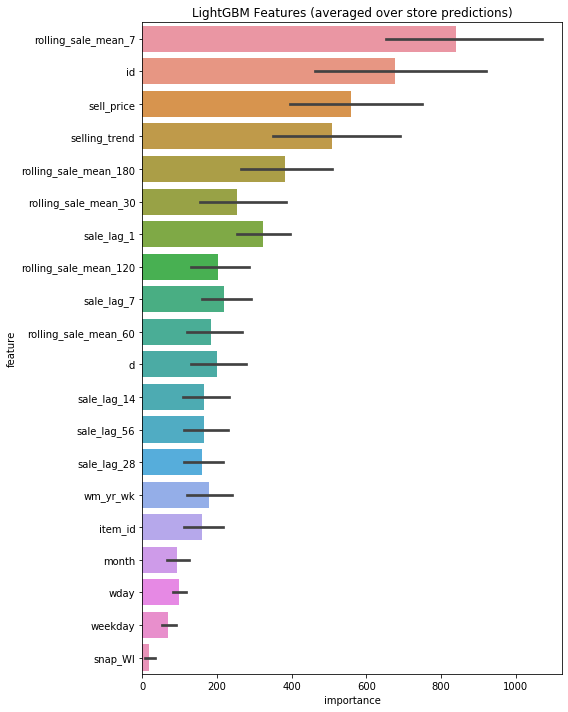

In [11]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sale']
for filename in os.listdir('./'):
    if 'model' in filename[:5]:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

## Store Submission

In [12]:
validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('../data/sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]


#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission_final_all.csv',index=False)